In [6]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [8]:
# a simple depolarising noise model where each of the three possible Pauli errors can be applied to a single qubit

dev1 = qml.device('default.mixed', wires=1)
@qml.qnode(dev1)
def depolarizing_circuit(p,wire):                       # p is the probablity of error inclusion
    
    qml.DepolarizingChannel(p, wire)
    return qml.expval(qml.PauliZ(0))                    # PauliZ is used as observable             

drawer = qml.draw(depolarizing_circuit)
print(drawer(p,0))




0: ──DepolarizingChannel(p)─┤  <Z>


In [164]:
# a no noise circuit preparing a bell circuit where observable is pauliZ

dev1 = qml.device('default.mixed', wires=2)

@qml.qnode(dev1)
def no_noise_circuit():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))


print(f"QNode output for noise-less = {no_noise_circuit():.4f}")

# a bell state preparing circuit with depolarizing noise, showing the effect of noise on expectation value

dev2 = qml.device('default.mixed', wires=2)
@qml.qnode(dev2)
def depolarizing_circuit(p):                                        # p is the probablity of error inclusion
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.DepolarizingChannel(p, wires=0)
    qml.DepolarizingChannel(p, wires=1)
    
    return qml.expval(qml.PauliZ(0)@qml.PauliZ(1))

drawer = qml.draw(depolarizing_circuit)
print(drawer(p))

error_prob = [0.05,0.1,0.2,0.3]
for prob in error_prob:
     print(f"QNode output for depolarizing probability {prob} is {depolarizing_circuit(prob):.4f}")

QNode output for noise-less = 1.0000
0: ──H─╭●──DepolarizingChannel(p)─┤ ╭<Z@Z>
1: ────╰X──DepolarizingChannel(p)─┤ ╰<Z@Z>
QNode output for depolarizing probability 0.05 is 0.8711
QNode output for depolarizing probability 0.1 is 0.7511
QNode output for depolarizing probability 0.2 is 0.5378
QNode output for depolarizing probability 0.3 is 0.3600


In [158]:
# now we apply unitary folding 

# we will take the error probablity to be 0.05 for the steps of unitary folding

p = 0.05

# operations contains the noisy gate and corresponding noisy inverse gate
# we use this to apply unitary folding
# it contains inverse gate and gate pairs with noise in order

operations = [qml.adjoint(qml.CNOT(wires=[0, 1])),
      qml.adjoint(qml.Hadamard(wires=0)),
      qml.DepolarizingChannel(p, wires=0),
      qml.DepolarizingChannel(p, wires=1),
      qml.Hadamard(wires=0),
      qml.CNOT(wires=[0, 1]),
      qml.DepolarizingChannel(p, wires=0),
      qml.DepolarizingChannel(p, wires=1)]

# each steps represent the number of time gate & inverse gate pairs is applied 

dev3 = qml.device('default.mixed', wires=2)

@qml.qnode(dev3)
def step0(p):         # p is the probablity of error inclusion           
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.DepolarizingChannel(p, wires=0)
    qml.DepolarizingChannel(p, wires=1)
    return qml.expval(qml.PauliZ(0)@qml.PauliZ(1))

@qml.qnode(dev3)
def step1(p):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.DepolarizingChannel(p, wires=0)
    qml.DepolarizingChannel(p, wires=1)
    for op in operations:
        qml.apply(op)
    return qml.expval(qml.PauliZ(0)@qml.PauliZ(1))
@qml.qnode(dev3)
def step2(p):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.DepolarizingChannel(p, wires=0)
    qml.DepolarizingChannel(p, wires=1)
    for i in range(2):
        for op in operations:
            qml.apply(op)
    
    return qml.expval(qml.PauliZ(0)@qml.PauliZ(1))

@qml.qnode(dev3)
def step3(p):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.DepolarizingChannel(p, wires=0)
    qml.DepolarizingChannel(p, wires=1)
    for i in range(3):
        for op in operations:
            qml.apply(op)
    
    return qml.expval(qml.PauliZ(0)@qml.PauliZ(1))
    

# the measurement is collected collectively for circuit, each time one gate-inverse gate pairs is added in the circuit

# error is intialized with 1, as the noise-less circuit output 1 as the measurement result
error = [1]  
error.append(step0(p))
error.append(step1(p))
error.append(step2(p))
error.append(step3(p))
error

[1, array(0.87111111), array(0.7082456), array(0.5758299), array(0.46817104)]

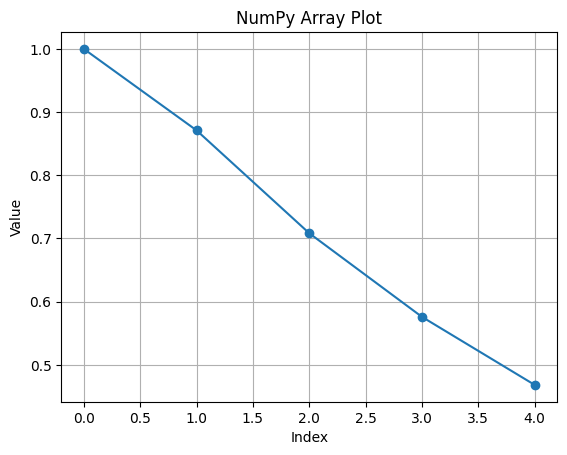

In [160]:
plt.plot(range(len(error)), error, marker='o', linestyle='-')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('NumPy Array Plot')
plt.grid(True)
plt.show()

# Now we will perform linear, polynomial and exponential fitting of the data to get value at zero-noise-limiting point

In [161]:
x_data = np.array([0,1,2,3,4])
y_data = error

# performing linear regression

model1 = np.polyfit(x_data, y_data, 1)
predict1 = np.poly1d(model1)


print("Extrapolated value for x using linear extrapolation =",0, ":", predict1(0))

# performing polynomial regression

model2 = np.polyfit(x_data, y_data, 2)             # qudratic polynomial extrapolation
predict2 = np.poly1d(model2)


print("Extrapolated value for x using polynomial extrapolation =",0, ":", predict2(0))

# performing exponential regression

model3 = np.polyfit(x_data,np.log(y_data),1,w=np.sqrt(y_data))        # the model will provide the coefficient A and B for y = Ae^(-Bx)

predict3 = np.exp(model3[1])*np.exp(0*model3[0])                        

print("Extrapolated value for x using polynomial extrapolation =",0, ":", predict3)



Extrapolated value for x using linear extrapolation = 0 : 0.9964593564048799
Extrapolated value for x using polynomial extrapolation = 0 : 1.0068750518109706
Extrapolated value for x using polynomial extrapolation = 0 : 1.023471952406809


# Thus the error mitigated expectation value is very close to 1

# Now we plot all the poly-fit and the real simulated result on the same graph

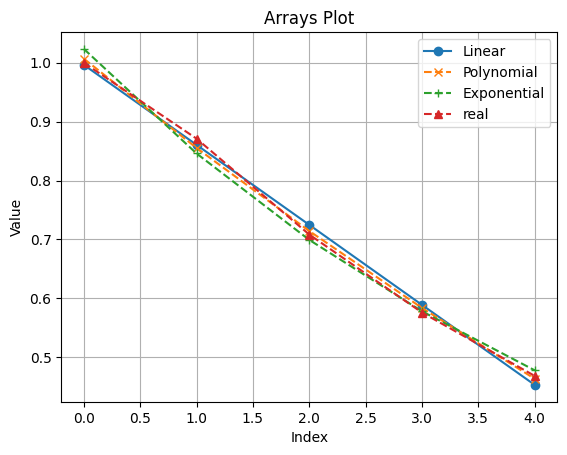

In [162]:
import numpy as np
import matplotlib.pyplot as plt

# Example arrays
array1 = predict1(range(5))
array2 = predict2(range(5))
array3 = []
for i in range(5):
    array3.append(np.exp(model3[1])*np.exp(i*model3[0]))

# Plot the arrays with indices on the same graph
plt.plot(range(len(array1)), array1, marker='o', linestyle='-', label='Linear')
plt.plot(range(len(array2)), array2, marker='x', linestyle='--', label='Polynomial')
plt.plot(range(len(array3)), array3, marker='+', linestyle='--', label='Exponential')
plt.plot(range(len(error)), error, marker='^', linestyle='--', label='real')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Arrays Plot')
plt.legend()
plt.grid(True)
plt.show()
